# 0. Libraries

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

from IPython.core.display import clear_output
!pip install -U geopandas mapclassify rtree folium matplotlib libpysal patsy contextily pydeck osmnx
clear_output()

In [ ]:
import pandas as pd 
pd.options.plotting.backend = 'plotly'
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import shutil
from glob import glob

import time
from tqdm import tqdm
tqdm.pandas()

from collections import Counter

import geopandas as gpd

import osmnx as ox

from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union

In [ ]:
## PyDeck
import pydeck as pdk

from pydeck.types import String as pdk_string

def create_pdk_text_layer(data, text, position = 'coordinates', size = 12, color = [0,0,0], angle = 0, text_anchor = 'middle', alignment_baseline = 'center', pickable = True):
  return pdk.Layer(
      'TextLayer',
      data,
      get_text = text,
      get_position = position,
      # Text styling and positioning
      get_size = size,
      get_color = color,
      get_angle = angle,
      get_text_anchor = pdk_string(text_anchor),
      get_alignment_baseline = pdk_string(alignment_baseline),
      # Interactivity
      pickable = pickable
  )

def create_pdk_polygon_layer(data, polygon, filled = True, fill_color = [255, 255, 255], opacity = 0.1, stroked = False, line_color = [255, 255, 255], line_width = 1, extruded = False, elevation = 0, wireframe = False, auto_highlight = True, pickable = True):
  return pdk.Layer(
      'PolygonLayer',
      data,
      get_polygon = polygon,
      # Fill
      filled = filled,
      get_fill_color = fill_color,
      opacity = opacity,
      # Border
      stroked = stroked,
      get_line_color = line_color,
      get_line_width = line_width,
      # Height
      extruded = extruded,
      get_elevation = elevation,
      # Surface
      wireframe = wireframe,
      # Interactivity
      auto_highlight = auto_highlight,
      pickable = pickable,
  )

def create_pdk_column_layer(data, position, radius = 100, coverage = 1, filled = True, fill_color = [255, 255, 255], opacity = 0.1, stroked = False, line_color = [255, 255, 255], line_width = 1, extruded = True, elevation = 0, elevation_scale = 100, wireframe = False, auto_highlight = True, pickable = True):
  return pdk.Layer(
      'ColumnLayer',
      data,
      get_position = position,
      # Column property
      radius = radius,
      coverage = coverage,
      # Fill
      filled = filled,
      get_fill_color = fill_color,
      opacity = opacity,
      # Border
      stroked = stroked,
      get_line_color = line_color,
      get_line_width = line_width,
      # Height
      extruded = extruded,
      get_elevation = elevation,
      elevation_scale = elevation_scale,
      # Surface
      wireframe = wireframe,
      # Interactivity
      auto_highlight = auto_highlight,
      pickable = pickable,
  )

def create_pdk_arc_layer(data, source_position, target_position, width = 1, height = 1, tilt = 0, great_circle = False, source_color = [255, 0, 0, 40], target_color = [0, 255, 0, 40], auto_highlight = True, pickable = True):
  return pdk.Layer(
      'ArcLayer',
      data,
      get_source_position = source_position,
      get_target_position = target_position,
      # Arc property
      get_width = width,
      get_height = height,
      get_tilt = tilt,
      great_circle = great_circle,
      # Fill
      get_source_color = source_color,
      get_target_color = target_color,
      # Interactivity
      auto_highlight = auto_highlight,
      pickable = pickable,
  )

def show_deck(layers, view, tooltip = True, iframe_height = 500, html_filepath = '/content/temp.html'):
  r = pdk.Deck( layers, initial_view_state=view, map_style=pdk.map_styles.DARK, tooltip = tooltip) # tooltip={'html': '<br>'.join(['<b>'+c+':</b> {'+c+'}' for c in tooltip_columns])}
  _ = r.to_html(html_filepath, iframe_height = iframe_height)

# 1. Util Functions

In [ ]:
def get_entries_and_exits_patterns(hourly_ridership, start_date, end_date):

  hourly_ridership_in_range = hourly_ridership[(hourly_ridership.timestamp >= start_date)&(hourly_ridership.timestamp <= end_date)]
  hourly_ridership_in_range['day_of_week'] = hourly_ridership_in_range['timestamp'].dt.day_of_week
  hourly_ridership_in_range['hour'] = hourly_ridership_in_range['timestamp'].dt.hour

  hourly_ridership_in_range_agg = hourly_ridership_in_range.groupby(['complex_id','day_of_week','hour']).agg({'entries':'mean','exits':'mean'}).round(0).astype(int).reset_index()

  all_complex_id_list = hourly_ridership_in_range_agg['complex_id'].unique().tolist()

  entries_patterns = {}
  for this_complex_id in all_complex_id_list:
    entries_pattern = pd.pivot_table(hourly_ridership_in_range_agg.query('complex_id == '+str(this_complex_id)), values='entries', index='hour', columns='day_of_week', aggfunc=np.sum, fill_value=0)
    entries_patterns[this_complex_id] = entries_pattern

  exits_patterns = {}
  for this_complex_id in all_complex_id_list:
    exits_pattern = pd.pivot_table(hourly_ridership_in_range_agg.query('complex_id == '+str(this_complex_id)), values='exits', index='hour', columns='day_of_week', aggfunc=np.sum, fill_value=0)
    exits_patterns[this_complex_id] = exits_pattern

  return entries_patterns, exits_patterns

def flatten_list(l):
  return [item for sublist in l for item in sublist]

def safe_log(m):
  # Reference: https://stackoverflow.com/a/52209380
  m = np.array(m, dtype=float)
  return np.log(m, out=np.zeros_like(m), where=(m!=0))

def standardize_column_names(df, custom_mapping = None):
  if custom_mapping is None:
    df.columns = [col.lower().replace(' ','_') for col in df.columns]
  else:
    df.columns = [custom_mapping[col] for col in df.columns]
  return df

def add_centroid_column(gdf, geom_column = 'geometry', proj2 = None, replace = False, return_new_column = False):
    
    new_column = geom_column if replace else geom_column + '_centroid'
    
    proj2 == '+proj=cea' if proj2 == 'cea' else proj2
    
    if proj2:
        gdf[new_column] = gdf[geom_column].to_crs(proj2).centroid.to_crs(gdf.crs)
    else:
        gdf[new_column] = gdf[geom_column].centroid
        
    if return_new_column:
        return gdf, new_column
    return gdf

def left_spatial_join(gdf1, gdf2):
    joined = gpd.sjoin(gdf1, gdf2, how='left')
    if 'index_right' in joined.columns:
        joined = joined.drop(['index_right'], axis=1)
    return joined
    

# 2. Data

## ridership

In [ ]:
hourly_ridership = pd.read_parquet('/content/drive/MyDrive/nyc_data/subway/combined_data_by_complex.parquet')

In [ ]:
# entries_patterns, exits_patterns = get_entries_and_exits_patterns(hourly_ridership, '2019-07-01', '2019-10-31')

# # complex id 2, namely the Astoria Boulevard station, was closed down for reconstruction in 2019, borrowing Q3 data from 2018 for this station
# entries_patterns_for_complex_2, exits_patterns_for_complex_2 = get_entries_and_exits_patterns(hourly_ridership.query('complex_id == 2'), '2018-07-01', '2018-10-31')

# entries_patterns[2] = entries_patterns_for_complex_2[2]
# exits_patterns[2] = exits_patterns_for_complex_2[2]

# # complex id 240 was closed down in 2018, so no data from 2019 onward is available, here we only consider complexes that have data for study period
# unique_complex_id_list = sorted(entries_patterns.keys())

# ridership_metrics_values = []
# for this_complex_id in unique_complex_id_list:
#   entries_pattern = entries_patterns[this_complex_id]
#   exits_pattern = exits_patterns[this_complex_id]
#   weekday_daily_entries = entries_pattern.iloc[:,:5].sum().sum()/5
#   weekday_daily_exits   = exits_pattern.iloc[:,:5].sum().sum()/5
#   weekend_daily_entries = entries_pattern.iloc[:,-2:].sum().sum()/2
#   weekend_daily_exits   = exits_pattern.iloc[:,-2:].sum().sum()/2
#   weekday_morning_hourly_entries = entries_pattern.iloc[6:9+1,:5].sum().sum()/5/4
#   weekday_morning_hourly_exits   = exits_pattern.iloc[6:9+1,:5].sum().sum()/5/4
#   weekday_evening_hourly_entries = entries_pattern.iloc[12+4:12+7+1,:5].sum().sum()/5/4
#   weekday_evening_hourly_exits   = exits_pattern.iloc[12+4:12+7+1,:5].sum().sum()/5/4
#   ridership_metrics_values.append((this_complex_id, weekday_daily_entries, weekday_daily_exits, weekend_daily_entries, weekend_daily_exits, weekday_morning_hourly_entries, weekday_morning_hourly_exits, weekday_evening_hourly_entries, weekday_evening_hourly_exits))

# ridership_metrics_as_of_2019Q3 = pd.DataFrame(ridership_metrics_values, columns = ['complex_id', 'weekday_daily_entries', 'weekday_daily_exits', 'weekend_daily_entries', 'weekend_daily_exits', 'weekday_morning_hourly_entries', 'weekday_morning_hourly_exits', 'weekday_evening_hourly_entries', 'weekday_evening_hourly_exits'])
# ridership_metrics_as_of_2019Q3.to_parquet(X '/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2019Q3.parquet')

ridership_metrics_as_of_2019Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2019Q3.parquet')

In [ ]:
# entries_patterns, exits_patterns = get_entries_and_exits_patterns(hourly_ridership, '2021-07-01', '2021-10-31')

# # complex id 301, namely the 181 St station, was closed down for reconstruction in 2021, borrowing Q3 data from 2020 for this station
# entries_patterns_for_complex_301, exits_patterns_for_complex_301 = get_entries_and_exits_patterns(hourly_ridership.query('complex_id == 301'), '2020-07-01', '2020-10-31')

# entries_patterns[301] = entries_patterns_for_complex_301[301]
# exits_patterns[301] = exits_patterns_for_complex_301[301]


# unique_complex_id_list = sorted(entries_patterns.keys())

# ridership_metrics_values = []
# for this_complex_id in unique_complex_id_list:
#   entries_pattern = entries_patterns[this_complex_id]
#   exits_pattern = exits_patterns[this_complex_id]
#   weekday_daily_entries = entries_pattern.iloc[:,:5].sum().sum()/5
#   weekday_daily_exits   = exits_pattern.iloc[:,:5].sum().sum()/5
#   weekend_daily_entries = entries_pattern.iloc[:,-2:].sum().sum()/2
#   weekend_daily_exits   = exits_pattern.iloc[:,-2:].sum().sum()/2
#   weekday_morning_hourly_entries = entries_pattern.iloc[6:9+1,:5].sum().sum()/5/4
#   weekday_morning_hourly_exits   = exits_pattern.iloc[6:9+1,:5].sum().sum()/5/4
#   weekday_evening_hourly_entries = entries_pattern.iloc[12+4:12+7+1,:5].sum().sum()/5/4
#   weekday_evening_hourly_exits   = exits_pattern.iloc[12+4:12+7+1,:5].sum().sum()/5/4
#   ridership_metrics_values.append((this_complex_id, weekday_daily_entries, weekday_daily_exits, weekend_daily_entries, weekend_daily_exits, weekday_morning_hourly_entries, weekday_morning_hourly_exits, weekday_evening_hourly_entries, weekday_evening_hourly_exits))

# ridership_metrics_as_of_2021Q3 = pd.DataFrame(ridership_metrics_values, columns = ['complex_id', 'weekday_daily_entries', 'weekday_daily_exits', 'weekend_daily_entries', 'weekend_daily_exits', 'weekday_morning_hourly_entries', 'weekday_morning_hourly_exits', 'weekday_evening_hourly_entries', 'weekday_evening_hourly_exits'])
# ridership_metrics_as_of_2021Q3.to_parquet(X '/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2021Q3.parquet')

ridership_metrics_as_of_2021Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2021Q3.parquet')

In [ ]:
ridership_metrics_recovery_rate = ridership_metrics_as_of_2021Q3.set_index('complex_id')/ridership_metrics_as_of_2019Q3.set_index('complex_id')

In [ ]:
ridership_metrics_recovery_rate

,weekday_daily_entries,weekday_daily_exits,weekend_daily_entries,weekend_daily_exits,weekday_morning_hourly_entries,weekday_morning_hourly_exits,weekday_evening_hourly_entries,weekday_evening_hourly_exits
complex_id,,,,,,,,
1,0.346564,0.502381,0.568060,0.783250,0.294443,0.794531,0.466621,0.439410
2,0.369801,0.586420,0.797786,0.944300,0.311134,0.751181,0.472154,0.529987
3,0.290864,0.533118,0.507617,0.966233,0.242326,0.728131,0.411938,0.473128
4,0.436795,0.630725,0.756614,1.263597,0.371429,0.869858,0.565213,0.550295
5,0.433819,0.627263,0.742792,1.308657,0.389937,0.728581,0.489854,0.563506
...,...,...,...,...,...,...,...,...
627,0.361611,0.560750,0.419745,0.649014,0.274867,0.699537,0.461159,0.478204
628,0.265733,0.403597,0.330839,0.634537,0.312146,0.352602,0.235716,0.472865
629,0.372383,0.803910,0.392023,0.759433,0.286298,0.908988,0.448680,0.732849


In [ ]:
unique_complex_id_list = ridership_metrics_recovery_rate.index.tolist()

## station meta

In [ ]:
subway_stations_meta = pd.read_csv('/content/drive/MyDrive/nyc_data/subway/tims_subway_stations_meta.csv')
subway_stations_meta = subway_stations_meta[subway_stations_meta['complex_id'].isin(unique_complex_id_list)]
complex_id_to_stop_name_mapping = subway_stations_meta.set_index('complex_id')['stop_name'].to_dict()

In [ ]:
subway_stations_meta['daytime_routes'] = subway_stations_meta['daytime_routes'].apply(lambda x : x.split())
subway_stations_meta = subway_stations_meta.reset_index(drop=True)
no_transfer_linked_complex_pairs = []
for _, row in subway_stations_meta.iterrows():
  for _, other_row in subway_stations_meta.iterrows():
    if len(set(row['daytime_routes']).intersection(set(other_row['daytime_routes'])))>0:
      if row['complex_id'] != other_row['complex_id']:
        no_transfer_linked_complex_pairs.append( (row['complex_id'], other_row['complex_id']) )
no_transfer_linked_complex_pairs_df = pd.DataFrame(no_transfer_linked_complex_pairs,columns=['from_complex','to_complex'])

## fare card composition [no need to run]

In [ ]:
card_type_breakdown = pd.read_parquet('/content/drive/MyDrive/nyc_data/subway/card_type_breakdown.parquet')

## isochrone

In [ ]:
complex_isochrone_df = gpd.read_feather('/content/drive/MyDrive/nyc_data/subway/complex_isochrone_df.feather')

## lodes

In [ ]:
geospatial_scope = 'proper' 
job_type = 'JT02'
file_year = 2019
wac_df = pd.read_parquet('/content/drive/MyDrive/nyc_data/demand/nyc_'+geospatial_scope+'_wac_'+job_type+'_'+str(file_year)+'.parquet')
rac_df = pd.read_parquet('/content/drive/MyDrive/nyc_data/demand/nyc_'+geospatial_scope+'_rac_'+job_type+'_'+str(file_year)+'.parquet')
block_gis = gpd.read_feather('/content/drive/MyDrive/nyc_data/demand/nyc_'+geospatial_scope+'_census_block_tiger_2010_augmented.feather')
block_gis.to_crs('epsg:4326',inplace=True)
wac_df.rename(columns={'w_geocode':'block_id'}, inplace=True)
rac_df.rename(columns={'h_geocode':'block_id'}, inplace=True)
block_gis.rename(columns={'BLOCKID10':'block_id'}, inplace=True)

In [ ]:
# complex_matched_blocks_df = (  left_spatial_join(complex_isochrone_df, block_gis[['block_id','geometry']])  ).groupby(['complex_id','trip_time'])['block_id'].apply(list).reset_index().rename(columns = {'block_id':'block_id_list'})
# complex_matched_blocks_df.to_parquet('/content/drive/MyDrive/nyc_data/analysis/complex_matched_blocks_df.parquet')

complex_matched_blocks_df = pd.read_parquet('/content/drive/MyDrive/nyc_data/analysis/complex_matched_blocks_df.parquet')

In [ ]:
od_df = pd.read_csv('/content/drive/MyDrive/nyc_data/demand/nyc_metro_lodes_2019.csv')

## uber traffic speed + osm bikable [no need to run]

### congestion level estimation from uber traffic data

In [ ]:
# !pip install pyrosm
# clear_output()

# from pyrosm import get_data
# fp = get_data('New York City')
# !mv '/tmp/pyrosm/newyorkcity.osm.pbf' '/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505.osm.pbf'

# from pyrosm import OSM
# osm = OSM('/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505.osm.pbf')
# nodes, edges = osm.get_network(nodes=True, network_type='driving')
# nodes.to_feather('/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505_nodes.feather')
# edges.to_feather('/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505_edges.feather')

In [ ]:
# hourly_weekly_traffic_speed_2019Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/road/hourly_weekly_traffic_speed_2019Q3.parquet')
# # example = hourly_weekly_traffic_speed_2019Q3.query('osm_way_id == 5029221 & osm_start_node_id == 278630910 & osm_end_node_id == 4209410680')
# example = hourly_weekly_traffic_speed_2019Q3.query('osm_way_id == 521149959 & osm_start_node_id == 2408448905 & osm_end_node_id == 42743020')
# street_name = edges.loc[edges.id==example.osm_way_id.tolist()[0],'name'].tolist()[0]
# example['time'] = example['day_of_week'].apply(lambda x: '2019-09-'+str(x+2).zfill(2)) + ' ' + example['hour'].apply(lambda x: str(x).zfill(2))
# example['time'] = pd.to_datetime(example['time'])
# example['speed'] = example['speed']/np.percentile(example['speed'],99)
# example.set_index('time')['speed'].plot(title = street_name)

In [ ]:
# hourly_weekly_traffic_speed_2019Q3['weekday'] = (hourly_weekly_traffic_speed_2019Q3['day_of_week']<=4).astype(int)
# hourly_weekly_traffic_speed_2019Q3['hour_group'] = hourly_weekly_traffic_speed_2019Q3['hour']//3*3
# weekday_vs_weekend_hour_group_traffic_speed_pattern_2019Q3 = hourly_weekly_traffic_speed_2019Q3.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id', 'weekday','hour_group']).agg({'speed':'median'}).reset_index()

In [ ]:
# ninty_nine_percentile_speed = hourly_weekly_traffic_speed_2019Q3.groupby(['osm_start_node_id','osm_end_node_id'])['speed'].apply(lambda li: np.percentile(li, 99)).rename('99pctile_speed').reset_index()
# hourly_weekly_traffic_speed_2019Q3 = pd.merge(hourly_weekly_traffic_speed_2019Q3, ninty_nine_percentile_speed)
# hourly_weekly_traffic_speed_2019Q3['relative_speed'] = hourly_weekly_traffic_speed_2019Q3['speed']/hourly_weekly_traffic_speed_2019Q3['99pctile_speed']

In [ ]:
# congestion = pd.concat([hourly_weekly_traffic_speed_2019Q3.groupby('osm_start_node_id').agg({'speed':lambda li: np.percentile(li, 5),'relative_speed':lambda li: np.percentile(li, 5)}).reset_index().rename(columns = {'osm_start_node_id':'id','speed':'absolute_low_speed','relative_speed':'relative_low_speed'})  , 
#                         hourly_weekly_traffic_speed_2019Q3.groupby('osm_end_node_id').agg({'speed':lambda li: np.percentile(li, 5),'relative_speed':lambda li: np.percentile(li, 5)}).reset_index().rename(columns = {'osm_end_node_id':'id','speed':'absolute_low_speed','relative_speed':'relative_low_speed'})  ])
# congestion = congestion.groupby('id').min().round(2).reset_index()

In [ ]:
# nodes = gpd.read_feather('/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505_nodes.feather')
# nodes = nodes[['id','geometry']].merge(congestion, on='id', how='inner')
# nodes.to_feather(X '/content/drive/MyDrive/nyc_data/analysis/osm_nodes_with_congestion_level.feather')

### proportion of road bikable from OSM data

In [ ]:
# edges = gpd.read_feather('/content/drive/MyDrive/nyc_data/osm/newyorkcity_v20220505_edges.feather')
# edges = edges[['id','cycleway','bicycle','geometry']]
# # edges['maxspeed'] = edges['maxspeed'].apply(lambda x: round(int(x.split()[0])*1.60934) if isinstance(x,str) and x.split()[0].isnumeric() else np.nan)
# edges['bicycle_friendly'] = edges['cycleway'].apply(lambda x: isinstance(x,str) and x!='no') | edges['bicycle'].isin(['yes','designated','permissive'])
# edges.drop(['cycleway','bicycle'], axis=1, inplace=True)
# edges.to_feather('/content/drive/MyDrive/nyc_data/analysis/osm_edges_with_bikable_info.feather')

## nyc sidewalk width [no need to run]

In [ ]:
# sidewalk_width = gpd.read_file('/content/drive/MyDrive/nyc_data/sidewalk/sidewalkwidths_nyc.geojson')
# sidewalk_width.to_feather('/content/drive/MyDrive/nyc_data/sidewalk/sidewalkwidths_nyc.feather')
sidewalk_width = gpd.read_feather('/content/drive/MyDrive/nyc_data/sidewalk/sidewalkwidths_nyc.feather')

# 3. Feature Merging

Isochrone set to 10 minutes trip time.

In [ ]:
trip_time_value = 10
complex_isochrone_df = complex_isochrone_df.query('trip_time == '+str(trip_time_value)).drop('trip_time', axis=1)

## Prediction Target (Ridership)

In [ ]:
ridership_metrics_as_of_2019Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2019Q3.parquet').set_index('complex_id')
ridership_metrics_as_of_2021Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/analysis/ridership_metrics_as_of_2021Q3.parquet').set_index('complex_id')
ridership_metrics_recovery_rate = (ridership_metrics_as_of_2021Q3/ridership_metrics_as_of_2019Q3).round(3)

## Card Type Features

In [ ]:
card_type_breakdown = pd.read_parquet('/content/drive/MyDrive/nyc_data/subway/card_type_breakdown.parquet')
card_type_breakdown_by_complex = card_type_breakdown.loc[card_type_breakdown['week_from_date'].dt.year == 2019].groupby('complex_id').mean()
card_type_breakdown_by_complex = card_type_breakdown_by_complex.div(card_type_breakdown_by_complex.sum(axis=1), axis=0).round(3)
card_type_breakdown_by_complex.columns = 'card_type__'+card_type_breakdown_by_complex.columns
card_type_breakdown_by_complex = card_type_breakdown_by_complex.reset_index()
card_type_breakdown_by_complex = card_type_breakdown_by_complex.drop(card_type_breakdown_by_complex.columns[-1],axis=1)
card_type_features_df = card_type_breakdown_by_complex

## LODES Features

### RAC and WAC

In [ ]:
lodes_features_list = []
for _ , row in complex_matched_blocks_df.query('trip_time == '+str(trip_time_value)).iterrows():
  this_complex_id = row['complex_id']
  this_complex_block_id_list = row['block_id_list']
  wac_features = wac_df.loc[wac_df['block_id'].isin(this_complex_block_id_list),wac_df.columns[1:]].sum()
  wac_features.index = 'w_'+wac_features.index
  rac_features = rac_df.loc[rac_df['block_id'].isin(this_complex_block_id_list),rac_df.columns[1:]].sum()
  rac_features.index = 'r_'+rac_features.index
  lodes_features = wac_features.append(rac_features)
  lodes_features.name = this_complex_id
  lodes_features_list.append(lodes_features)
lodes_features_df = pd.concat(lodes_features_list, axis=1)
lodes_features_df = lodes_features_df.T.reset_index().rename(columns={'index':'complex_id'})
lodes_features_df_orig = lodes_features_df.copy()

In [ ]:
selected_lodes_feature_names = [col for col in lodes_features_df.columns.tolist() if not ('__' in col) and len(re.findall(r'age_mid|earn_mid|sec_other|race_hawai|ethn_nonh|edu_lowh|sex_m|firmage_0|firmsize_0$',col))==0]
lodes_features_df = lodes_features_df_orig.copy()
lodes_features_df = lodes_features_df[selected_lodes_feature_names]
w_proportion_features = [col for col in lodes_features_df.columns if col.startswith('w_') and col != 'w_num_of_jobs']
r_proportion_features = [col for col in lodes_features_df.columns if col.startswith('r_') and col != 'r_num_of_jobs']
lodes_features_df[w_proportion_features] = lodes_features_df[w_proportion_features].div(lodes_features_df['w_num_of_jobs'], axis=0)
lodes_features_df[r_proportion_features] = lodes_features_df[r_proportion_features].div(lodes_features_df['r_num_of_jobs'], axis=0)

### OD

In [ ]:
complex_id_to_block_id_list_mapping = complex_matched_blocks_df.query('trip_time == '+str(trip_time_value)).set_index('complex_id')['block_id_list']

from_complex_no_transfer_linked_blocks = no_transfer_linked_complex_pairs_df.groupby('from_complex')['to_complex'].apply(list).apply(lambda li: set(flatten_list([complex_id_to_block_id_list_mapping.get(x, []) for x in li])))

from_complex_no_transfer_linked_blocks = from_complex_no_transfer_linked_blocks.rename('to_complexes_blocks').reset_index()

from_complex_no_transfer_linked_blocks['from_complex_blocks'] = from_complex_no_transfer_linked_blocks['from_complex'].map(complex_id_to_block_id_list_mapping)

no_transfer_linked_blocks = from_complex_no_transfer_linked_blocks.dropna()

no_transfer_linked_flow_data = []

for _, row in no_transfer_linked_blocks.iterrows():
  this_complex_id = row['from_complex']
  block_id_pairs = []
  for from_b in row['from_complex_blocks']:
    for to_b in row['to_complexes_blocks']:
      block_id_pairs.append( (to_b, from_b) )
  block_id_pairs_df = pd.DataFrame(block_id_pairs, columns=['w_geocode','h_geocode'])
  od_departing_from_this_complex = pd.merge(od_df, block_id_pairs_df)

  S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03 = od_departing_from_this_complex.drop(['w_geocode','h_geocode'],axis=1).sum()
  flow_size = S000
  if S000 == 0: 
    continue
  age_you_prop = SA01/S000
  age_old_prop = SA03/S000
  earn_low_prop = SE01/S000
  earn_high_prop = SE03/S000
  production_prop = SI01/S000
  trade_prop =  SI02/S000

  no_transfer_linked_flow_data.append( ( this_complex_id, flow_size, age_you_prop, age_old_prop, earn_low_prop, earn_high_prop, production_prop, trade_prop ) )

no_transfer_linked_flow_df = pd.DataFrame(no_transfer_linked_flow_data, columns = 'complex_id, flow_size, age_you_prop, age_old_prop, earn_low_prop, earn_high_prop, production_prop, trade_prop'.split(', '))

no_transfer_linked_flow_df.to_parquet('/content/drive/MyDrive/nyc_data/analysis/no_transfer_linked_flow.parquet')

In [ ]:
lodes_features_df = no_transfer_linked_flow_df.copy()

## Congestion Features

In [ ]:
congestion_nodes = gpd.read_feather('/content/drive/MyDrive/nyc_data/analysis/osm_nodes_with_congestion_level.feather')

In [ ]:
complex_congestion_df = left_spatial_join(complex_isochrone_df, congestion_nodes)

complex_congestion_df = complex_congestion_df.drop(['id','geometry'],axis=1).groupby(['complex_id']).mean().round(2).reset_index()
complex_congestion_df['congestion_level'] = 1 - complex_congestion_df['relative_low_speed']

congestion_features_df = complex_congestion_df[['complex_id','congestion_level']]

## Bikable Features

In [ ]:
bikable_edges = gpd.read_feather('/content/drive/MyDrive/nyc_data/analysis/osm_edges_with_bikable_info.feather')

In [ ]:
bikable_edges['edge_length'] = bikable_edges['geometry'].to_crs('epsg:2263').length

In [ ]:
complex_bikable_df = left_spatial_join(complex_isochrone_df, bikable_edges)

complex_bikable_df = complex_bikable_df.groupby(['complex_id','bicycle_friendly'])['edge_length'].sum().reset_index()
bikable_features_df = (complex_bikable_df[complex_bikable_df['bicycle_friendly']].groupby('complex_id')['edge_length'].sum() / complex_bikable_df.groupby('complex_id')['edge_length'].sum()).round(3).rename('bicycle_friendly_proportion').reset_index()

# bikable_features_df['name'] = bikable_features_df['complex_id'].map(complex_id_to_stop_name_mapping)
# bikable_features_df.sort_values('bicycle_friendly_proportion', ascending=False)

## Facilities Features

In [ ]:
# facilities = gpd.read_file('/content/drive/MyDrive/nyc_data/facilities/city_facilities_20210811.gpkg').to_crs('epsg:4326')
# facilities = facilities[['FACGROUP', 'FACDOMAIN', 'SERVAREA','geometry']]
# facilities.to_feather('/content/drive/MyDrive/nyc_data/facilities/city_facilities_20210811.feather')
facilities = gpd.read_feather('/content/drive/MyDrive/nyc_data/facilities/city_facilities_20210811.feather')

complex_facilities_df = left_spatial_join(complex_isochrone_df, facilities)
complex_facilities_df['SERVAREA'] = complex_facilities_df['SERVAREA'].map({'Regional':2,'Local':1})
complex_facilities_df = complex_facilities_df.groupby(['complex_id','FACGROUP'])['SERVAREA'].sum().reset_index()
complex_facilities_df = pd.pivot_table(complex_facilities_df, values='SERVAREA', index='complex_id', columns='FACGROUP', fill_value=0)
complex_facilities_df.columns = ['facilities__'+re.sub(r'[^a-z1-9 ]','',col.lower()).replace(' ','_') for col in complex_facilities_df.columns]

facilities_features_df = complex_facilities_df.reset_index()

In [ ]:
facilities_[facilities_['FACGROUP']=='TRANSPORTATION'].FACSUBGRP.value_counts()

PARKING LOTS AND GARAGES      2544
RAIL YARDS AND MAINTENANCE     360
OTHER TRANSPORTATION           201
BUS DEPOTS AND TERMINALS       144
PORTS AND FERRY LANDINGS        87
AIRPORTS AND HELIPORTS          30
Name: FACSUBGRP, dtype: int64

## Combine Features

And handle perfect colinearity

In [ ]:
features_df = pd.concat([df.set_index('complex_id') for df in [card_type_features_df, lodes_features_df, congestion_features_df, bikable_features_df, facilities_features_df]], axis=1)
features_df = features_df.dropna()
# features_df.to_parquet('/content/drive/MyDrive/nyc_data/analysis/features_df_v4.parquet')

# Regression Models

In [ ]:
Xy_df = pd.merge(features_df, ridership_metrics_recovery_rate, left_index = True, right_index = True, how='inner')

all_feature_names = Xy_df.columns[:-8]

X = Xy_df[all_feature_names].values

# ['weekday_daily_entries',
#  'weekday_daily_exits',
#  'weekend_daily_entries',
#  'weekend_daily_exits',
#  'weekday_morning_hourly_entries',
#  'weekday_morning_hourly_exits',
#  'weekday_evening_hourly_entries',
#  'weekday_evening_hourly_exits']
target_column = 'weekday_morning_hourly_exits'
y = Xy_df[target_column].values

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import plotly.express as px

def evaluate_pred(y_test, y_pred, show=False):
  mae = mean_absolute_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)  
  r2 = r2_score(y_test, y_pred)
  print('MAE:', round(mae,2), '  RMSE:',round(rmse,2), '  R^2:', round(r2,2))
  if show:
    fig = px.scatter(x = y_test, y = y_pred)
    fig.update_layout(
        title='Test Set Prediction Result - MAE: '+str(round(mae,2))+'  R^2: '+str(round(r2,2)),
        xaxis_title="Ground Truth",
        yaxis_title="Prediction")
    return fig

def show_weights(model, full = False):
  try:
    feature_weight_df = pd.DataFrame(zip(all_feature_names, model.coef_),columns=['feature_name','feature_weight'])
    feature_weight_df = feature_weight_df.sort_values('feature_weight', ascending=False)
  except:
    feature_weight_df = pd.DataFrame(zip(all_feature_names, model.feature_importances_),columns=['feature_name','feature_importance'])
    feature_weight_df = feature_weight_df.sort_values('feature_importance', ascending=False)
  if full:
    return feature_weight_df
  return feature_weight_df.head(10).append(feature_weight_df.tail(10))

In [ ]:
_, X_test_complex_id, _, _  = train_test_split(Xy_df[all_feature_names], y, test_size = 0.2, random_state=42)
X_test_complex_id_list = X_test_complex_id.index.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_std, y_train)

LinearRegression()

In [ ]:
evaluate_pred(y_train, linear_reg.predict(X_train_std) )

MAE: 0.07   RMSE: 0.09   R^2: 0.72


In [ ]:
evaluate_pred(y_test, linear_reg.predict(X_test_std), show=True)

MAE: 0.11   RMSE: 0.16   R^2: 0.26


In [ ]:
show_weights(linear_reg)

,feature_name,feature_weight
72,r_race_black,2.172006
71,r_race_white,1.707104
74,r_race_asian,1.304261
51,r_earn_high,0.270053
79,r_edu_bach,0.150201
73,r_race_amind,0.108802
1,card_type__30_day_unlimited,0.082819
76,r_ethn_hisp,0.067148
48,r_age_you,0.059644
25,w_sec_health,0.056180


In [ ]:
# !pip install xgboost==1.0.1
import xgboost
from xgboost import XGBRegressor

In [ ]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, eta=0.1, subsample=0.7, colsample_bytree=0.7, tree_method='hist', 
                         objective = 'reg:squarederror', eval_metric = 'auc')

In [ ]:
xgb_model.fit(X_train_std,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.1,
             eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.100000001,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='hist',
             validate_parameters=False, verbosity=None)

In [ ]:
evaluate_pred(y_test, xgb_model.predict(X_test_std), show=True)

MAE: 0.09   RMSE: 0.14   R^2: 0.41


In [ ]:
# !pip install shap
# clear_output()
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_std)

X_display = pd.DataFrame(X_test, columns=all_feature_names)

In [ ]:
# [complex_id_to_stop_name_mapping[x] for x in X_test_complex_id_list].index('111 St')

In [ ]:
shap.initjs()
i = 0
orig_index = list((y == y_test[i]).astype(int)).index(1)
stop_name = complex_id_to_stop_name_mapping[Xy_df[orig_index:orig_index+1].index.tolist()[0]]
print(' '*48+stop_name)
shap.force_plot(explainer.expected_value, shap_values[i,:], X_display.iloc[i,:])

                                                18 St


In [ ]:
shap.initjs()
i = 11
orig_index = list((y == y_test[i]).astype(int)).index(1)
stop_name = complex_id_to_stop_name_mapping[Xy_df[orig_index:orig_index+1].index.tolist()[0]]
print(' '*45+stop_name)
shap.force_plot(explainer.expected_value, shap_values[i,:], X_display.iloc[i,:])

                                             Beverly Rd


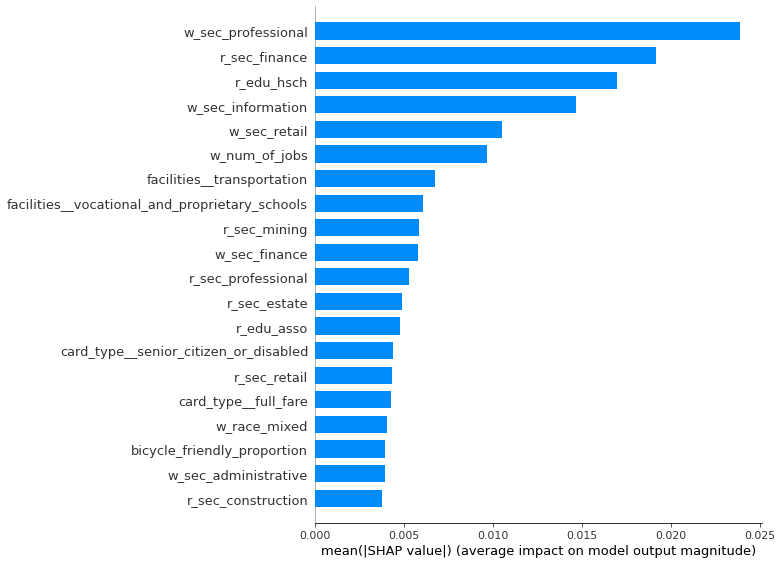

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

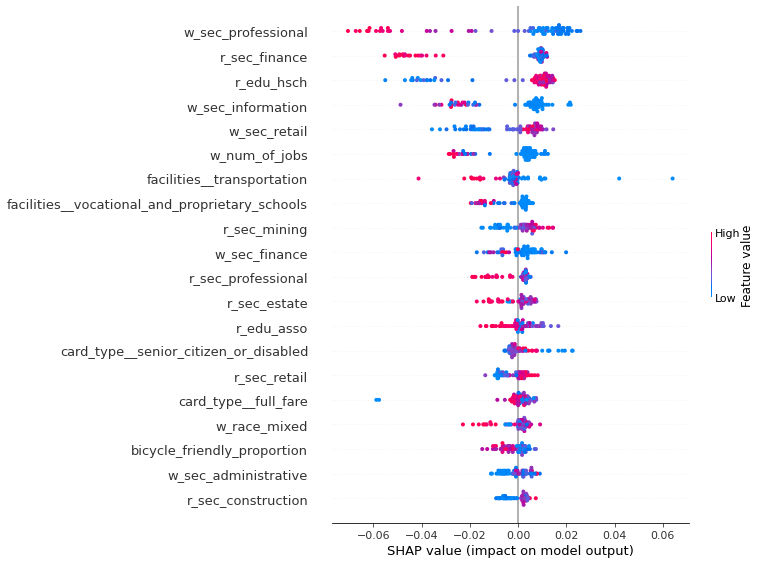

In [ ]:
shap.summary_plot(shap_values, X_display)